### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ae5d395a-b66e-60fa-374f-a311fa9ae0c5)


In [3]:
!git clone https://github.com/RishiDarkDevil/daam-i2i.git

Cloning into 'daam-i2i'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 668 (delta 119), reused 153 (delta 90), pack-reused 478
Receiving objects: 100% (668/668), 778.49 KiB | 6.65 MiB/s, done.
Resolving deltas: 100% (294/294), done.


In [4]:
cd daam-i2i

/content/daam-i2i


In [4]:
# %cd ..

In [2]:
# import shutil
# shutil.rmtree('daam-i2i')

In [5]:
ls

daami2i/  docs/        LICENSE      README.md         scrollbar.css
data/     example.jpg  MANIFEST.in  requirements.txt  setup.py


In [6]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [7]:
# General
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2


# Image Generation
from diffusers import StableDiffusionPipeline
import daami2i

# Model
import torch

### Load Model

In [8]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [9]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [10]:
prompt = 'Dinner table with chairs and flower pot'

In [11]:
prompt = 'A boy standing on a mountain.'

In [12]:
prompt = 'longhorn cattle inspect the vehicle'

In [13]:
prompt = 'Chicken Fajita'

In [14]:
prompt = 'Chicken Pizza with lots of vegetables'

In [15]:
# self-attention
with daami2i.trace(model) as trc:
  output_image = model(prompt).images
  global_heat_map = trc.compute_global_heat_map()

  0%|          | 0/51 [00:00<?, ?it/s]

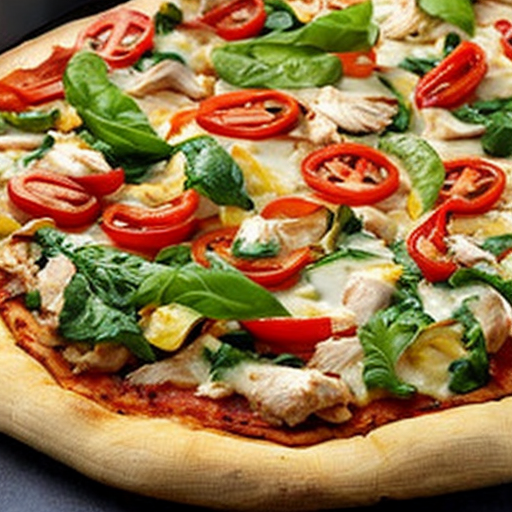

In [16]:
output_image[0]

In [17]:
global_heat_map.heat_maps.shape

torch.Size([4096, 64, 64])

In [18]:
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
torch.cuda.empty_cache()

/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


### Visualize Image Attentions

There are 3 types of visualizations available:
- Pixel-based here. The pixels are numbered in row-major order i.e.
  - 1     2 .. 64\
  4033 4034 .. 4096\
  Only latent image height and width is valid i.e. 64 x 64 so the pixels that can be mentioned is a list from 1 ... 4096.

- BBox based here. The bounding box upper left and bottom right corner needs to be specified. Again latent height and width are valid ranges.

- Contour based here. The image height and width can be different from the latent height and width. Enter contour and attention map will be generated for that contour containing pixels.

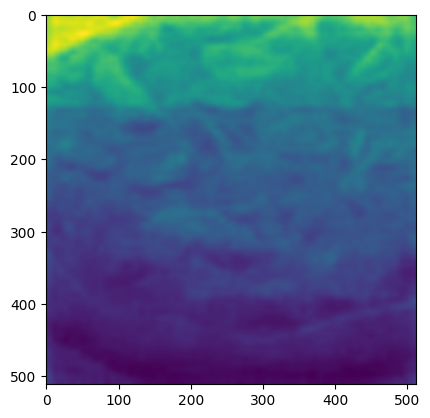

In [20]:
# Compute heatmap for latent pixel lists row-major
pixel_heatmap = global_heat_map.compute_pixel_heat_map(list(range(1024))).expand_as(output_image[0]).numpy()

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

plt.imshow(heatmap)

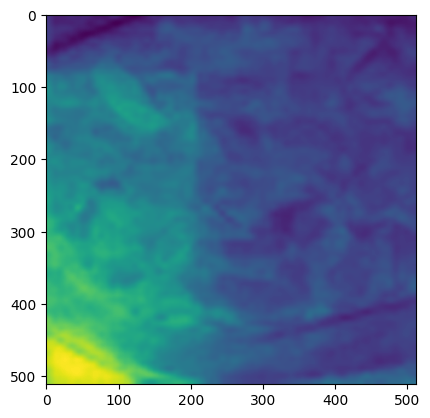

In [21]:
# Compute heatmap for latent bbox pixels with corners specified
pixel_heatmap = global_heat_map.compute_bbox_heat_map(0,10,25,64).expand_as(output_image[0]).numpy()

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

plt.imshow(heatmap)

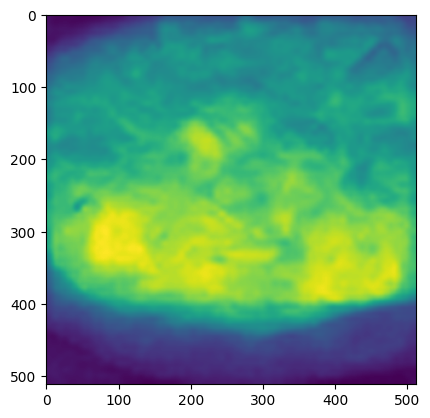

In [24]:
# Compute heatmap for inner pixels for contour boundary specified
pixel_heatmap = global_heat_map.compute_contour_heat_map([[0,300], [256, 100], [512, 300], [512, 400], [0, 400], [0, 300]], 512, 512).expand_as(output_image[0]).numpy()

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

plt.imshow(heatmap)